# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные.

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [10]:
# Импортируем библиотеки
!pip install sqlalchemy
!pip install psycopg2-binary 
!pip install dotenv
import os

import pandas as pd
from sqlalchemy import create_engine 
import dotenv
import matplotlib.pyplot as plt
import seaborn as sns

!pip install phik -U
from phik import phik_matrix



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [11]:
#Конфигурация подключения к базе
dotenv.load_dotenv()

db_config = {'user': os.getenv('DB_USER'),
             'pwd': os.getenv('DB_PWD'),
             'host': os.getenv('DB_HOST'),
             'port': os.getenv('DB_PORT'),
             'db': os.getenv('DB_NAME')
             }
connection_template = 'postgresql://{user}:{pwd}@{host}:{port}/{db}'
engine = create_engine(connection_template.format(**db_config)) 

In [12]:
#Запрос в DB
query = '''
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk as order_dt,
    p.created_ts_msk as order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    (p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk::DATE
    )) AS days_since_prev,
    p.event_id,
    event_name_code as event_name,
    event_type_main,
    service_name,
    region_name,
    city_name
FROM afisha.purchases AS p
LEFT JOIN afisha.events as e using (event_id)
LEFT JOIN afisha.city as c using (city_id)
LEFT JOIN afisha.regions as r using (region_id)
WHERE p.device_type_canonical IN ('mobile', 'desktop') 
  AND event_type_main != 'фильм'
ORDER BY p.user_id
'''

In [13]:
# Выгружаем данные в переменную
purchases_df = pd.read_sql_query(query, con=engine) 

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

Познакомимся с данными датасета из базы `data-analyst-afisha` — выведем первые строки методом `head()`, а информацию о датафрейме методом `info()`:

In [14]:
# Выводим первые строки датафрейма на экран
purchases_df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [15]:
# Выводим информацию о датафрейме
purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Датасет `data-analyst-afisha` содержит 14 столбцов и 290611 строк, в которых представлена информация развлекательных событиях сервиса Афиша.

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов уже приведены к одному виду.
- Столбцы `user_id`, `event_name` содержат текстовые значения и хранятся в типах данных `object`, что соответствует своему описанию.
- Столбцы `device_type_canonical`, `currency_code`, `event_type_main`, `service_name`, `region_name`, `city_name` содержат категориальные признаки и хранятся в типах данных `object`, тип данных этих столбцов следует привести к типу `category`.
- Столбец `revenue`  содержит числа с плавающей точкой и хранится в типе данных `float64`, размерность этих данных можно оптимизировать.
- Столбец `days_since_prev`  содержит целые числа, однако определен как `float64` из-за пропусков тип данных стоит изменить на `int64` и размерность этих данных можно оптимизировать.
- Столбец `tickets_count`  содержит целые числа и хранится в типе данных `int64`, размерность этих данных можно оптимизировать.
- Столбцы `order_id` и `event_id` содержат целочисленные значения и хранятся в типах данных `int64`, размерность этих данных можно попытаться оптимизировать.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

---

#### Промежуточный вывод

По первому знакомству с данными в датасете есть пропуски данных в `data-analyst-afisha` есть пропуски в одной колонке `days_since_prev`.
Названия столбцов в датасете приведены к одному виду, типы данных в датасете нужно оптимизировать типы и размерность данных.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:


In [16]:
# Выгружаем данные в переменную
final_tickets_tenge_df = pd.read_csv('http://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

Познакомимся с данными датасета `final_tickets_tenge_df.csv` — выведем первые строки методом head(), а информацию о датафрейме методом info():

In [17]:
# Выводим первые строки датафрейма на экран
final_tickets_tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [18]:
# Выводим информацию о датафрейме
final_tickets_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Датасет `final_tickets_tenge_df.csv` содержит 4 столбцов и 357 строк, в которых представлена информация о курсах валюты kzt за 2024 год.

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов уже приведены к одному виду.
- Столбцы `data` содержит информацию о дате и хранится в типк данных `object`, тип данных следует привести к типу `datetime64`.
- Столбец `nominal` содержит целые числа и хранится в типе данных `int64`, размерность этих данных можно оптимизировать.
- Столбец `curs` содержит числа с плавающей точкой и хранится в типе данных `float64`, размерность этих данных можно оптимизировать.
- Столбец `cdx` содержит категориальную информацию и хранится в типе данных `object`, тип данных следует преобразовать в `category`.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

In [19]:
#Приведение типа данных столбца `data` для возможности слияния датасетов
final_tickets_tenge_df['data'] = pd.to_datetime(final_tickets_tenge_df['data'])

In [20]:
#Подготовка единого датафрейма
df = purchases_df.merge(final_tickets_tenge_df, left_on='order_dt', right_on='data', how='left')

In [21]:
# Класс нормализации типов данных датафрейма
class DataFrameNormalizer:
    def __init__(self, df):
        self.df = df
        
    def run(self,
        to_int: list = None, 
        to_float: list = None, 
        to_category: list = None, 
        to_date: list = None
    ) -> pd.DataFrame:
        original_df = self.df.copy()
        if to_int:
            self.to_int(to_int)
        if to_float:
            self.to_float(to_float)
        if to_category:
            self.to_category(to_category)
        if to_date:
            self.to_date(to_date)
        return pd.concat([
            original_df.dtypes.rename('До изменений'),
            self.df.dtypes.rename('После изменений')
        ], axis=1)

    def to_int(self, columns: list) -> None:
        for column in columns:
            self.df[column] = pd.to_numeric(self.df[column], downcast='integer')
     
    def to_float(self, columns: list) -> None:
        for column in columns:
            self.df[column] = pd.to_numeric(self.df[column], downcast='float')
    
    def to_category(self, columns: list) -> None:
        for column in columns:
            self.df[column] = df[column].astype('category')
    
    def to_date(self, columns: list) -> None:
        for column in columns:
            self.df[column] = pd.to_datetime(self.df[column])


In [22]:
#Приводим типы данных к целевому виду
categories = ('device_type_canonical', 'currency_code', 'event_type_main', 
              'service_name', 'region_name', 'city_name', 'cdx')
int64s = ('tickets_count', 'order_id', 'event_id', 'nominal')
float64s = ('revenue', 'curs')
DataFrameNormalizer(df).run(to_int=int64s, to_category=categories, to_float=float64s)

,До изменений,После изменений
user_id,object,object
device_type_canonical,object,category
order_id,int64,int32
order_dt,datetime64[ns],datetime64[ns]
order_ts,datetime64[ns],datetime64[ns]
currency_code,object,category
revenue,float64,float64
tickets_count,int64,int8
days_since_prev,float64,float64
event_id,int64,int32


In [23]:
# Посчитаем количество и доли пропусков в столбцах
def show_missing_stats(tmp_df):
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': tmp_df.isnull().sum(),
        'Доля пропусков': tmp_df.isnull().mean().round(4)
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    return missing_stats.style.background_gradient(cmap='coolwarm') if not missing_stats.empty else "Пропусков в данных нет"
show_missing_stats(df)

,Кол-во пропусков,Доля пропусков
days_since_prev,21933,0.075500


В датафрейме `df` обнаружено 
- 21933 пропусков в столбце `days_since_prev` — это 7% данных. Пропуски в этом столбце связаны с тем, что являются первыми покупками уникальных пользователей, так как нет даты предыдущей покупки.

Пропуски можно оставить как есть, так как это ожидаемое поведение.

In [24]:
# Посчитаем количество уникальных значений в категориальных столбцах
def show_uniques_stats(tmp_df, columns):
    uniques = {col: tmp_df[col].nunique() for col in columns}
    uniques_stats = pd.DataFrame(list(uniques.items()), columns=["Столбец", "Уникальных значений"])
    return uniques_stats.style.background_gradient(cmap='coolwarm').set_caption("Статистика уникальных значений")
show_uniques_stats(df, categories)

,Столбец,Уникальных значений
0,device_type_canonical,2
1,currency_code,2
2,event_type_main,7
3,service_name,36
4,region_name,81
5,city_name,352
6,cdx,1


In [25]:
class DataFrameReporter:
    def __init__(self, float_format='0.05f', percent_format='0.02%', include_all=False):
        self.float_format = float_format
        self.percent_format = percent_format
        self.include_all = include_all
    
    def show_report(self, df, title=None):
        if title:
            print(title)
        print('Количество столбцов:', df.shape[1])
        print('Количество строк:', df.shape[0])
        duplicates = df.duplicated().sum()
        print('Количество дубликатов:', duplicates)
        print('Доля дубликатов:', format(duplicates / df.shape[0], self.percent_format))
        print(df.describe(include='all' if self.include_all else None))        
        print('Количество пропусков:', df.isna().sum().sum())
        
        isna = df.isna().mean(axis=None).sum()
        print('Доля пропусков:', format(isna, self.float_format))
    
    @staticmethod
    def count_duplicates(df, columns):
        duplicates_per_column = {col: df[col].duplicated().sum() for col in df.columns}
        duplicates_per_column_stats = pd.DataFrame.from_dict(
            duplicates_per_column, orient='index', columns=['Количество дубликатов'])
        return duplicates_per_column_stats.style.background_gradient(cmap='coolwarm').set_caption("Статистика дубликатов по столбцам")

    @staticmethod
    def show_implicit_duplicates_stats(df, columns):
        duplicates = {col: df[col].nunique() - df[col].str.strip().str.lower().nunique() for col in columns}
        duplicates_stats = pd.DataFrame(list(duplicates.items()), columns=["Столбец", "Неявных дубликатов"])
        return duplicates_stats.style.background_gradient(cmap='coolwarm').set_caption("Статистика неявных дубликатов")


In [26]:
#Выведем отчет по датасету df
reporter = DataFrameReporter(float_format='0.03f', percent_format='0.02%')
reporter.show_report(df, 'Отчёт по общему датасету:')

Отчёт по общему датасету:
Количество столбцов: 19
Количество строк: 290611
Количество дубликатов: 0
Доля дубликатов: 0.00%
           order_id                       order_dt  \
count  2.906110e+05                         290611   
mean   4.326225e+06  2024-09-01 22:36:38.741272576   
min    1.000000e+00            2024-06-01 00:00:00   
25%    2.163618e+06            2024-07-30 00:00:00   
50%    4.326366e+06            2024-09-12 00:00:00   
75%    6.488330e+06            2024-10-09 00:00:00   
max    8.653108e+06            2024-10-31 00:00:00   
std    2.497551e+06                            NaN   

                            order_ts        revenue  tickets_count  \
count                         290611  290611.000000  290611.000000   
mean   2024-09-02 13:31:19.397731072     625.584360       2.754311   
min              2024-06-01 00:00:42     -90.760000       1.000000   
25%       2024-07-30 11:53:37.500000     116.850000       2.000000   
50%              2024-09-12 14:02:10    

In [27]:
# Посчитаем количество неявных дупликатов в столбцах
reporter.count_duplicates(df, categories)

,Количество дубликатов
user_id,268678
device_type_canonical,290609
order_id,0
order_dt,290458
order_ts,9858
currency_code,290609
revenue,248089
tickets_count,290589
days_since_prev,290461
event_id,268184


In [28]:
# Посчитаем количество неявных дупликатов в столбцах
reporter.show_implicit_duplicates_stats(df, categories)

,Столбец,Неявных дубликатов
0,device_type_canonical,0
1,currency_code,0
2,event_type_main,0
3,service_name,0
4,region_name,0
5,city_name,0
6,cdx,0


Так как в столбах `cdx` и `nominal` содержится только по одному уникальному значению, эти столбцы можно удалить, запомнив эти параметры.

In [29]:
#Удаляем столбец `cdx`
df = df.drop(['cdx', 'nominal'], axis=1)
nominal = 100

---

#### Промежуточный вывод

В результате предобработки данных были выполнены следующие действия:

- Изучены пропуски в данных. Пропуски обнаружились в столбце `days_since_prev` и составляют от 7% данных. Пропуски по этим данным говорят о том, что это первая покупка пользователя, по-этому их оставили как есть.
- Данные проверили на явные и неявные дубликаты — в данных нет ни явных дупликатов, не неявных.
---

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---

In [30]:
#Пересчитаем тенге в рубли в новом столбце 'revenue_rub'
def calculate_revenue_rub(row):
    if row['currency_code'] == 'kzt':
        return row['revenue'] / nominal * row['curs']
    else:
        return row['revenue']
df['revenue_rub'] = df.apply(calculate_revenue_rub, axis=1)

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

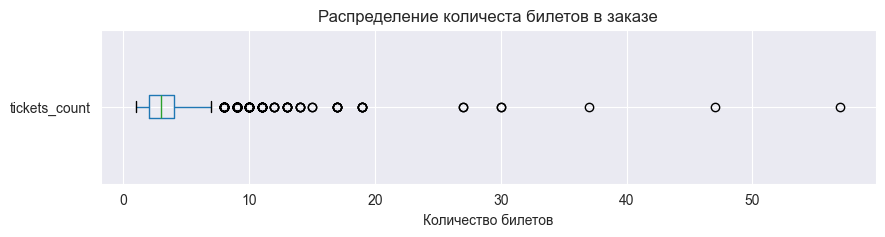

In [31]:
# Распределение количеста билетов в заказе
def value_distribution(df, column, title, xlabel, figsize=(10, 2), vert=False):
    plt.figure(figsize=figsize)
    df.boxplot(column=column, vert=vert)
    plt.title(title)
    plt.xlabel(xlabel)
    return plt.show()

value_distribution(df, 'tickets_count', 'Распределение количеста билетов в заказе', 'Количество билетов')

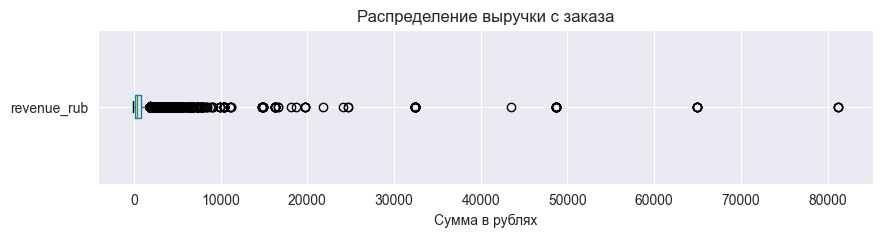

In [32]:
# Распределение выручки с заказа
value_distribution(df, 'revenue_rub', 'Распределение выручки с заказа', 'Сумма в рублях')

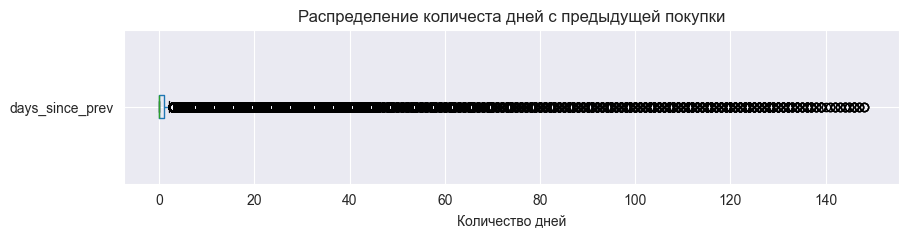

In [33]:
# Распределение количеста дней с предыдущей покупки
value_distribution(df, 'days_since_prev', 'Распределение количеста дней с предыдущей покупки', 'Количество дней')

In [34]:
# В столбце `revenue_rub` есть выбросы, отфильтруем по 99 перцентилю
percentile_99 = df['revenue_rub'].quantile(0.99)
filtered_df = df[df['revenue_rub'] <= percentile_99]

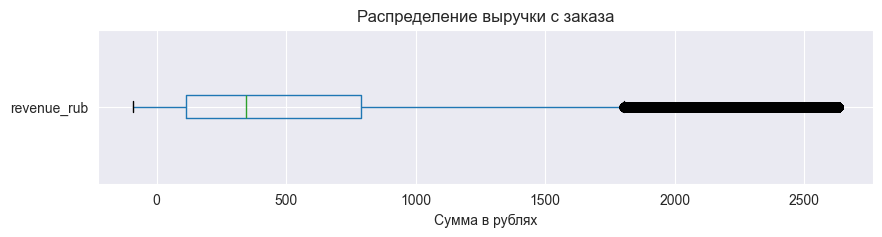

In [35]:
# Распределение выручки с заказа отфильтрованое по 99 перцентилю
value_distribution(filtered_df, 'revenue_rub', 'Распределение выручки с заказа', 'Сумма в рублях')

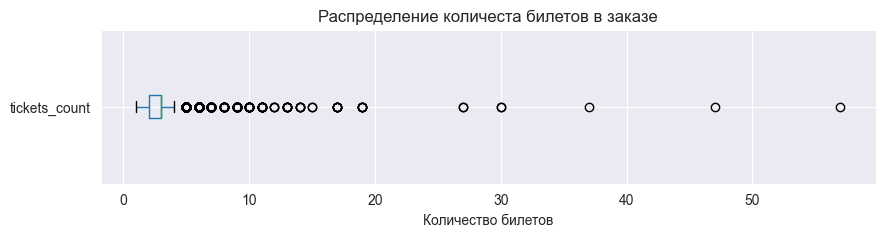

In [36]:
# # Распределение количеста билетов в заказе отфильтрованое по 99 перцентилю
value_distribution(filtered_df, 'tickets_count', 'Распределение количеста билетов в заказе', 'Количество билетов')

In [37]:
# Количество строк отфильтрованых по 99 перцентилю
df.size - filtered_df.size

50850

In [38]:
# Доля строк отфильтрованых по 99 перцентилю
round((df.size - filtered_df.size) / df.size, 4)

0.0097

---

#### Промежуточный вывод

В результате предобработки данных были выполнены следующие действия:

- Изучены пропуски в данных. Пропуски обнаружились в столбце `days_since_prev` и составляют от 7% данных. Пропуски по этим данным говорят о том, что это первая покупка пользователя, по-этому их оставили как есть.
- Данные проверили на явные и неявные дубликаты — в данных нет ни явных дупликатов, не неявных.
- Преобразованы стобцы:
    - `device_type_canonical`, `currency_code`, `event_type_main`, `service_name`, `region_name`, `city_name` преобразованы в тип `category`
    - `order_id` и `event_id` оптимизирована размерность до  `int32`
    - `revenue` и `curs` оптимизирована размерность до `float32`
    - `ticket_count` оптимизирована размерность до i8
- Удалены столбцы `cdx` и `nominal` так как в них содержится только одно значение.
- Так как в столбце `revenue_rub` большое количество выбросов, они были отфильтрованы по перцентилю 99, исключено 50850 строк что составляет долю 0.0097 от общего числа в датафрейме.
---

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [39]:
# Построим профиль для пользоватей
users_profile = filtered_df.sort_values(by='order_ts').groupby('user_id').agg({
    'order_dt': ['min', 'max'],
    'device_type_canonical': 'first',
    'region_name': 'first',
    'service_name': 'first',
    'event_type_main': 'first',
    'order_id': 'count',
    'revenue_rub': 'mean',
    'tickets_count': 'mean',
    'days_since_prev': 'mean'
}).reset_index()
users_profile.columns = [
    'user_id',
    'first_order_dt', 'last_order_dt',
    'first_device_type',
    'first_region_name',
    'first_service_name',
    'first_event_type',
    'total_orders',
    'avg_revenue',
    'avg_tickets_count',
    'avg_days_between_orders'
]
users_profile

,user_id,first_order_dt,last_order_dt,first_device_type,first_region_name,first_service_name,first_event_type,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.000
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.000
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.000
...,...,...,...,...,...,...,...,...,...,...,...
21849,fff13b79bd47d7c,2024-07-16,2024-10-31,mobile,Каменевский регион,Мой билет,другое,9,688.043333,2.555556,13.375
21850,fff32fc9ad0f9f6,2024-08-15,2024-10-28,desktop,Каменевский регион,Билеты без проблем,стендап,2,850.995000,2.500000,74.000
21851,fffcd3dde79eb2c,2024-06-20,2024-10-30,desktop,Каменевский регион,Билеты без проблем,концерты,33,557.908485,2.787879,4.125
21852,fffeeb3c120cf0b,2024-09-24,2024-09-24,desktop,Широковская область,Билеты без проблем,стендап,1,661.530000,2.000000,NaN


In [40]:
# Добавим признак того что пользователь совершил 2 и более заказов 
def ge_num(row, num):
    if row['total_orders'] >= num:
        return 1
    else:
        return 0
users_profile['is_two'] = users_profile.apply(lambda row: ge_num(row, 2), axis=1)

In [41]:
# Добавим признак того что пользователь совершил 5 и более заказов 
users_profile['is_five'] = users_profile.apply(lambda row: ge_num(row, 5), axis=1)

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [42]:
# Построим профиль для пользоватей
reporter2 = DataFrameReporter(float_format='0.03f', percent_format='0.02%')
reporter2.show_report(users_profile, 'Отчёт по профилю пользователей:')

Отчёт по профилю пользователей:
Количество столбцов: 13
Количество строк: 21854
Количество дубликатов: 0
Доля дубликатов: 0.00%
                      first_order_dt                  last_order_dt  \
count                          21854                          21854   
mean   2024-08-09 22:54:06.490344960  2024-09-18 08:06:52.482840832   
min              2024-06-01 00:00:00            2024-06-01 00:00:00   
25%              2024-06-25 00:00:00            2024-08-25 00:00:00   
50%              2024-08-09 00:00:00            2024-10-03 00:00:00   
75%              2024-09-23 00:00:00            2024-10-22 00:00:00   
max              2024-10-31 00:00:00            2024-10-31 00:00:00   
std                              NaN                            NaN   

       total_orders   avg_revenue  avg_tickets_count  avg_days_between_orders  \
count  21854.000000  21854.000000       21854.000000             13518.000000   
mean      13.168573    544.398051           2.743129                15

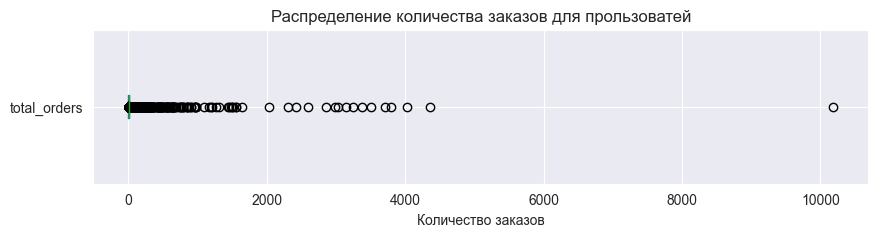

In [43]:
# Распределение количества заказов для прользоватей
value_distribution(users_profile, 'total_orders', 'Распределение количества заказов для прользоватей', 'Количество заказов')

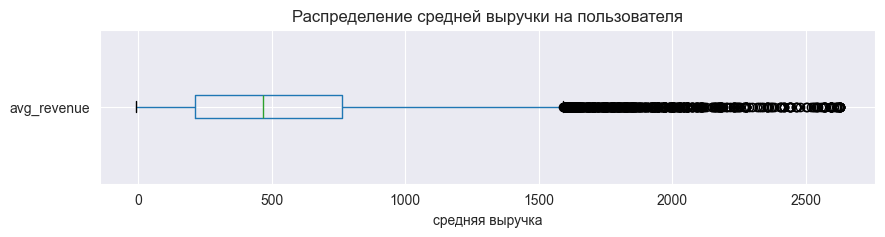

In [44]:
# Распределение средней выручки на пользователя
value_distribution(users_profile, 'avg_revenue', 'Распределение средней выручки на пользователя', 'средняя выручка')

In [45]:
# Общее количество заказов
users_profile['total_orders'].sum()

np.int64(287786)

In [46]:
users_profile[users_profile['total_orders'] > 2000]

,user_id,first_order_dt,last_order_dt,first_device_type,first_region_name,first_service_name,first_event_type,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders,is_two,is_five
235,02ea4583333f064,2024-06-01,2024-10-31,mobile,Широковская область,Облачко,концерты,2980,574.973510,2.716779,0.050352,1,1
981,0beb8fc0c0a9ce1,2024-06-01,2024-10-31,mobile,Североярская область,Билеты в руки,концерты,10181,505.152314,2.862587,0.014637,1,1
2054,18e9aead0a393e7,2024-06-01,2024-10-31,mobile,Каменевский регион,Облачко,концерты,4351,494.827281,2.788784,0.034483,1,1
2330,1c2a2133e1df1b4,2024-06-01,2024-10-31,mobile,Североярская область,Реестр,концерты,3503,541.560246,2.669997,0.042262,1,1
3806,2c8092b69b753cc,2024-06-01,2024-10-31,mobile,Каменевский регион,Билеты без проблем,другое,2036,462.734491,2.501473,0.073710,1,1
5414,3ee7dc2e115847f,2024-06-01,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,3791,536.949699,2.764970,0.039578,1,1
5935,44c1c640a242aea,2024-06-01,2024-10-31,mobile,Чистогорская область,Билеты в руки,концерты,2313,540.248655,2.699092,0.064879,1,1
6776,4ec8f6429431987,2024-06-01,2024-10-31,mobile,Североярская область,Реестр,концерты,3375,549.785176,2.725926,0.044458,1,1
10669,7d22e22c99ec66e,2024-06-01,2024-10-31,mobile,Североярская область,Лови билет!,концерты,2597,551.215255,2.901040,0.057011,1,1
10810,7eb4fc207ecc10f,2024-06-01,2024-10-31,mobile,Каменевский регион,Билеты без проблем,театр,3710,542.634237,2.956334,0.040442,1,1


In [47]:
# В столбце `total_orders` есть выбросы, отфильтруем по 95 перцентилю
percentile_99 = users_profile['total_orders'].quantile(0.99)
filtered_users_profile = users_profile[users_profile['total_orders'] <= percentile_99]

In [48]:
# В столбце `avg_revenue` есть выбросы, отфильтруем отрицательные значения
filtered_users_profile = filtered_users_profile[filtered_users_profile['avg_revenue'] >= 0]

In [49]:
# Доля строк отфильтрованых по 95 перцентилю
count = users_profile.size - filtered_users_profile.size
share = round((users_profile.size - filtered_users_profile.size) / users_profile.size, 4)
print('Количество удаленных строк:', count)
print('Доля удаленных строк:', share)

Количество удаленных строк: 3016
Доля удаленных строк: 0.0106


In [50]:
# Построим профиль для пользоватей
reporter3 = DataFrameReporter(float_format='0.03f', percent_format='0.02%')
reporter3.show_report(filtered_users_profile, 'Отчёт по обновленному датасету:')

Отчёт по обновленному датасету:
Количество столбцов: 13
Количество строк: 21622
Количество дубликатов: 0
Доля дубликатов: 0.00%
                      first_order_dt                  last_order_dt  \
count                          21622                          21622   
mean   2024-08-10 15:25:19.452409600  2024-09-17 22:46:04.517620992   
min              2024-06-01 00:00:00            2024-06-01 00:00:00   
25%              2024-06-26 00:00:00            2024-08-24 00:00:00   
50%              2024-08-09 12:00:00            2024-10-02 00:00:00   
75%              2024-09-23 00:00:00            2024-10-22 00:00:00   
max              2024-10-31 00:00:00            2024-10-31 00:00:00   
std                              NaN                            NaN   

       total_orders   avg_revenue  avg_tickets_count  avg_days_between_orders  \
count  21622.000000  21622.000000       21622.000000             13296.000000   
mean       6.504949    545.113080           2.743881                16

---
Общее число пользователей в выборке 20745;
средняя выручка с одного заказа 547;
доля пользователей, совершивших 2 и более заказа 0.59;
доля пользователей, совершивших 5 и более заказов 0.25.

Статистические показатели:
общее число заказов 287786;
среднее число билетов в заказе 2.74;
среднее количество дней между покупками 17.04.
В данных обнаружено аномально высокое количество заказов на пользователя в ряде случаев, данные по этому показателю отфильтруем по 99-му перцентилю, так как эти выбросы скорее всего связаны с не обычными пользователями, а перекупщиками и они исказят результаты дальнейшего анализа.
В данных так же обнаружены аномальные заказы с отрицательной выручкой, их тоже отфильтровали в датасете.

Количество удаленных из датасета строк 14417, что составляет 5%.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [51]:
# функция рисования нескольких графиков распределения
def subplot_distribution(tmp_df, title, xlabel, ylabel, kind, figsize=(10, 6), legend=False, axis='x'):
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    

    for index, column in enumerate(tmp_df.columns):
        if index % 2 == 1:
            tmp_df.plot(kind=kind,  y=column, ax=axes[index], legend=legend, color='darkorange')
        else:
            tmp_df.plot(kind=kind,  y=column, ax=axes[index], legend=legend)
        axes[index].set_title(title)
        axes[index].set_ylabel(xlabel)
        axes[index].set_xlabel(ylabel[index])        
        axes[index].grid(axis=axis)

    plt.tight_layout()
    plt.show()

In [52]:
def df_groupby_count_share(tmp_df, groupby):
    result = tmp_df.groupby(groupby).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)
    result['user_share'] = round(result['user_id'] / result['user_id'].sum(), 2)
    result.columns = ['user_count', 'user_share']
    return result

In [53]:
# Распределение типов первого мероприятия пользователей
first_event_df = df_groupby_count_share(filtered_users_profile, 'first_event_type')
first_event_df

/var/folders/z6/jblpqz354lbgcwl5ph1gnkr00000gn/T/ipykernel_20300/3216612262.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = tmp_df.groupby(groupby).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)


,user_count,user_share
first_event_type,,
концерты,9560,0.44
другое,5411,0.25
театр,4239,0.20
стендап,1110,0.05
спорт,794,0.04
выставки,413,0.02
ёлки,95,0.00


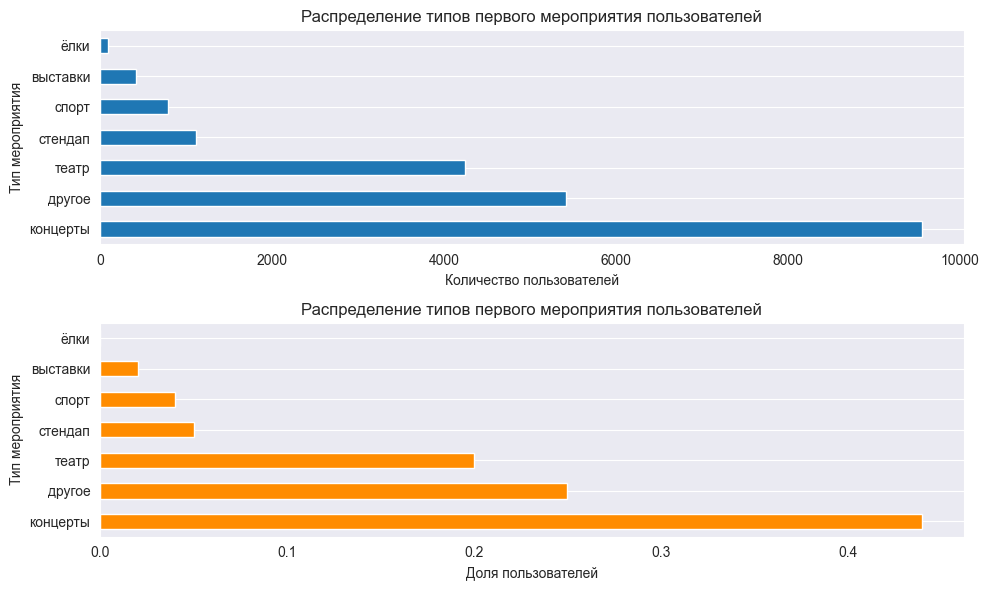

In [54]:
# Распределение типов первого мероприятия пользователей
subplot_distribution(first_event_df, 'Распределение типов первого мероприятия пользователей', 
                     'Тип мероприятия', ['Количество пользователей', 'Доля пользователей'], kind='barh')

Более 44% пользователей сделали первый заказ на концерт.

In [55]:
# Распределение типов первого устройства пользователей
first_device_df = df_groupby_count_share(filtered_users_profile, 'first_device_type')
first_device_df

/var/folders/z6/jblpqz354lbgcwl5ph1gnkr00000gn/T/ipykernel_20300/3216612262.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = tmp_df.groupby(groupby).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)


,user_count,user_share
first_device_type,,
mobile,17908,0.83
desktop,3714,0.17


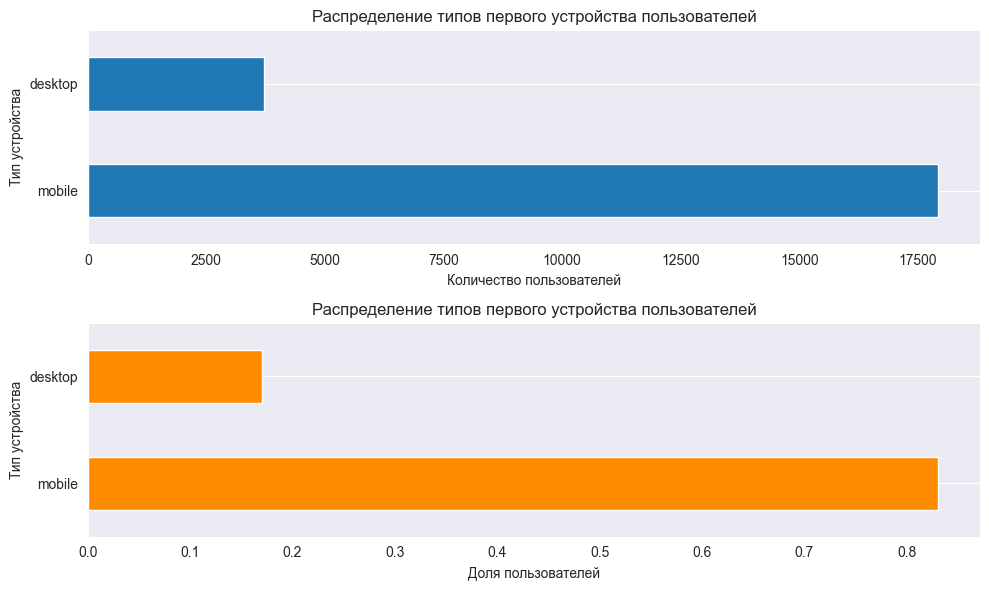

In [56]:
# Распределение типов первого устройства пользователей
subplot_distribution(first_device_df, 'Распределение типов первого устройства пользователей', 
                     'Тип устройства', ['Количество пользователей', 'Доля пользователей'], kind='barh')

Более 83% пользователей сделали первый заказ с мобильного устройства.

In [57]:
# Распределение типов первого региона пользователей
first_region_df = df_groupby_count_share(filtered_users_profile, 'first_region_name').head(10)
first_region_df

/var/folders/z6/jblpqz354lbgcwl5ph1gnkr00000gn/T/ipykernel_20300/3216612262.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = tmp_df.groupby(groupby).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)


,user_count,user_share
first_region_name,,
Каменевский регион,7085,0.33
Североярская область,3767,0.17
Широковская область,1223,0.06
Озернинский край,675,0.03
Малиновоярский округ,525,0.02
Шанырский регион,500,0.02
Травяная область,488,0.02
Светополянский округ,457,0.02
Речиновская область,440,0.02


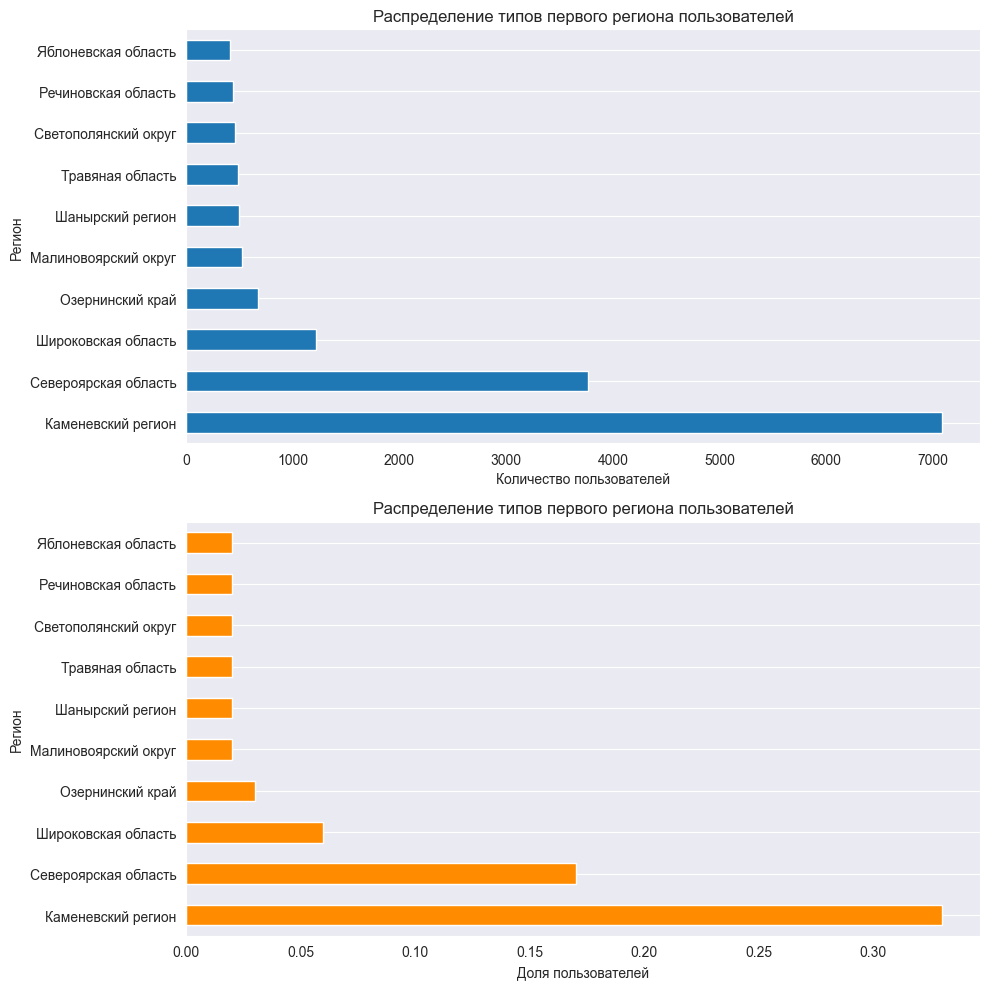

In [58]:
# Распределение типов первого региона пользователей
subplot_distribution(first_region_df, 'Распределение типов первого региона пользователей', 
                     'Регион', ['Количество пользователей', 'Доля пользователей'], kind='barh',
                     figsize=(10, 10))

Более 33% пользователей сделали первый заказ из каменевского региона и более 17 из североярскогой области.

In [59]:
# Распределение типов первого региона пользователей
first_service_df = df_groupby_count_share(filtered_users_profile, 'first_service_name').head(10)
first_service_df

/var/folders/z6/jblpqz354lbgcwl5ph1gnkr00000gn/T/ipykernel_20300/3216612262.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = tmp_df.groupby(groupby).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)


,user_count,user_share
first_service_name,,
Билеты без проблем,5176,0.24
Мой билет,2969,0.14
Лови билет!,2808,0.13
Билеты в руки,2556,0.12
Облачко,2177,0.10
Весь в билетах,1285,0.06
Лучшие билеты,1182,0.05
Прачечная,583,0.03
Край билетов,454,0.02


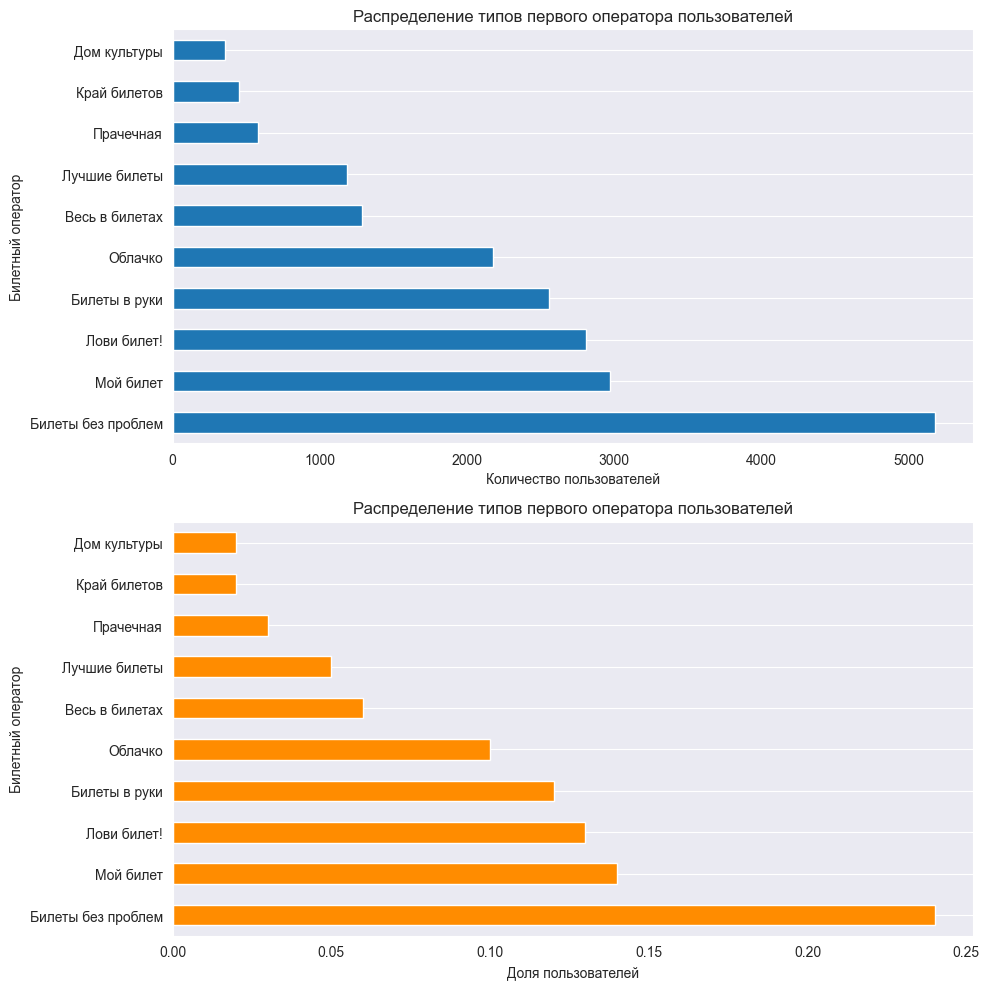

In [60]:
# Распределение типов первого устройства пользователей
subplot_distribution(first_service_df, 'Распределение типов первого оператора пользователей', 
                     'Билетный оператор', ['Количество пользователей', 'Доля пользователей'], kind='barh',
                    figsize=(10, 10))

Более 24% пользователей сделали первый заказ у оператора "Билет без проблем".

---
Распределение пользователей тяготеет к определенным категориям:
- 44% пользователей сделали первый заказ на концерт, 25% пользователей выбрали "другое".
- 83% пользователей сделали первый заказ с мобильного устройства.
- Наибольшее количество пользователей 33% делали первый заказ из каменевского региона и около 17% из североярскогой области.
- Более 24% пользователей сделали первый заказ у оператора "Билет без проблем", остальные операторы в топ-5 по доле пользователей попали операторы с долями от 10% до 14% .

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [61]:
filtered_users_profile_is_two = filtered_users_profile[filtered_users_profile['is_two'] == 1]

In [62]:
# Распределение типов первого мероприятия пользователей совершивших 2 и более заказа
first_event_df_2 = df_groupby_count_share(
    filtered_users_profile_is_two, 'first_event_type')
first_event_df_2

/var/folders/z6/jblpqz354lbgcwl5ph1gnkr00000gn/T/ipykernel_20300/3216612262.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = tmp_df.groupby(groupby).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)


,user_count,user_share
first_event_type,,
концерты,5911,0.45
другое,3229,0.24
театр,2687,0.20
стендап,676,0.05
спорт,443,0.03
выставки,265,0.02
ёлки,53,0.00


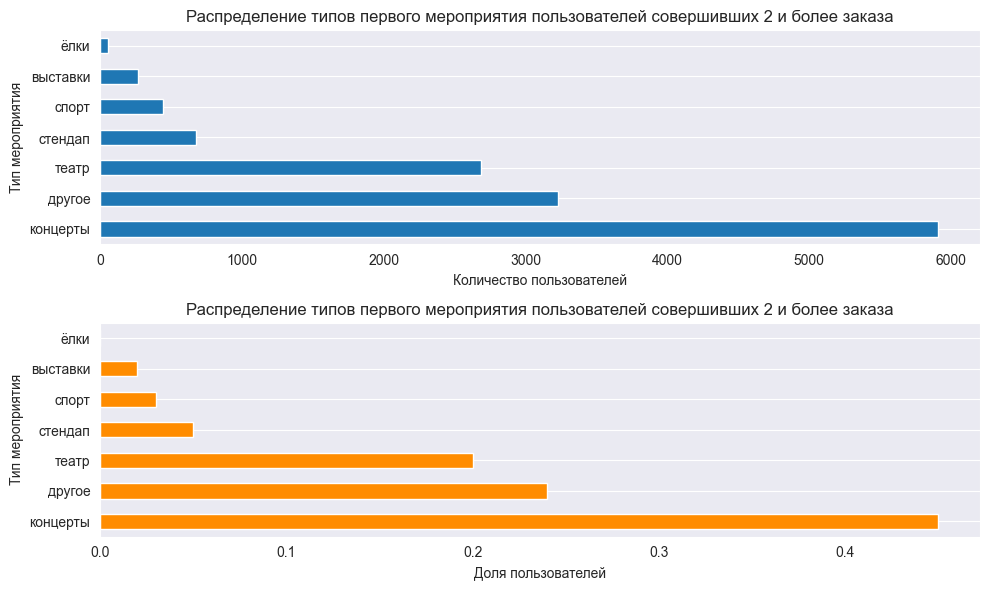

In [63]:
# Распределение типов первого мероприятия пользователей совершивших 2 и более заказа
subplot_distribution(first_event_df_2, 'Распределение типов первого мероприятия пользователей совершивших 2 и более заказа', 
                     'Тип мероприятия', ['Количество пользователей', 'Доля пользователей'], kind='barh')

Доля пользователей, совершивших 2 и более заказов, первым заказом выбравших концерты  0.45 против общей выборки 0.44. "Другое" 0.24 против 0.25 в общей выборке.

Пользователи совершившие 2 и более заказа в качестве первого мероприятия выбрали концерты, на их долю приходится 0.45.

In [64]:
# Распределение типов первого устройства пользователей совершивших 2 и более заказа
first_device_df_2 = df_groupby_count_share(
    filtered_users_profile_is_two, 'first_device_type')
first_device_df_2

/var/folders/z6/jblpqz354lbgcwl5ph1gnkr00000gn/T/ipykernel_20300/3216612262.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = tmp_df.groupby(groupby).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)


,user_count,user_share
first_device_type,,
mobile,10894,0.82
desktop,2370,0.18


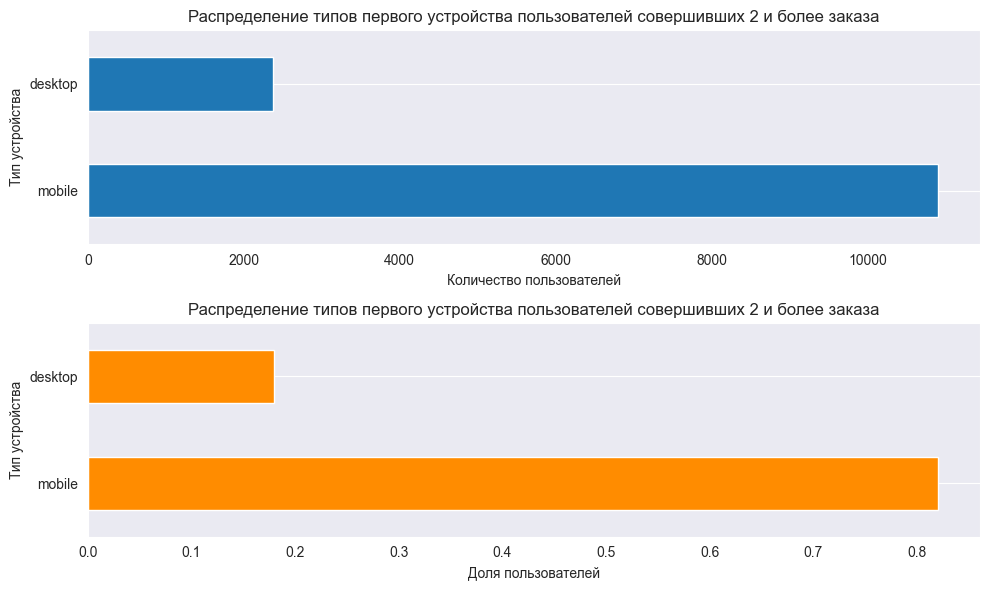

In [65]:
# Распределение типов первого устройства пользователей совершивших 2 и более заказа
subplot_distribution(first_device_df_2, 'Распределение типов первого устройства пользователей совершивших 2 и более заказа', 
                     'Тип устройства', ['Количество пользователей', 'Доля пользователей'], kind='barh')

Доля пользователей в сделавших первый заказ через мобильное приложение для пользователей, совершивших 2 и более заказов, почти без изменений (0.83) в сравнении с общей выборкой.

In [66]:
# Распределение типов первого региона пользователей совершивших 2 и более заказов
first_region_df_2 = df_groupby_count_share(filtered_users_profile_is_two, 'first_region_name').head(10)
first_region_df_2

/var/folders/z6/jblpqz354lbgcwl5ph1gnkr00000gn/T/ipykernel_20300/3216612262.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = tmp_df.groupby(groupby).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)


,user_count,user_share
first_region_name,,
Каменевский регион,4421,0.33
Североярская область,2404,0.18
Широковская область,789,0.06
Озернинский край,373,0.03
Шанырский регион,336,0.03
Травяная область,300,0.02
Светополянский округ,300,0.02
Малиновоярский округ,294,0.02
Речиновская область,279,0.02


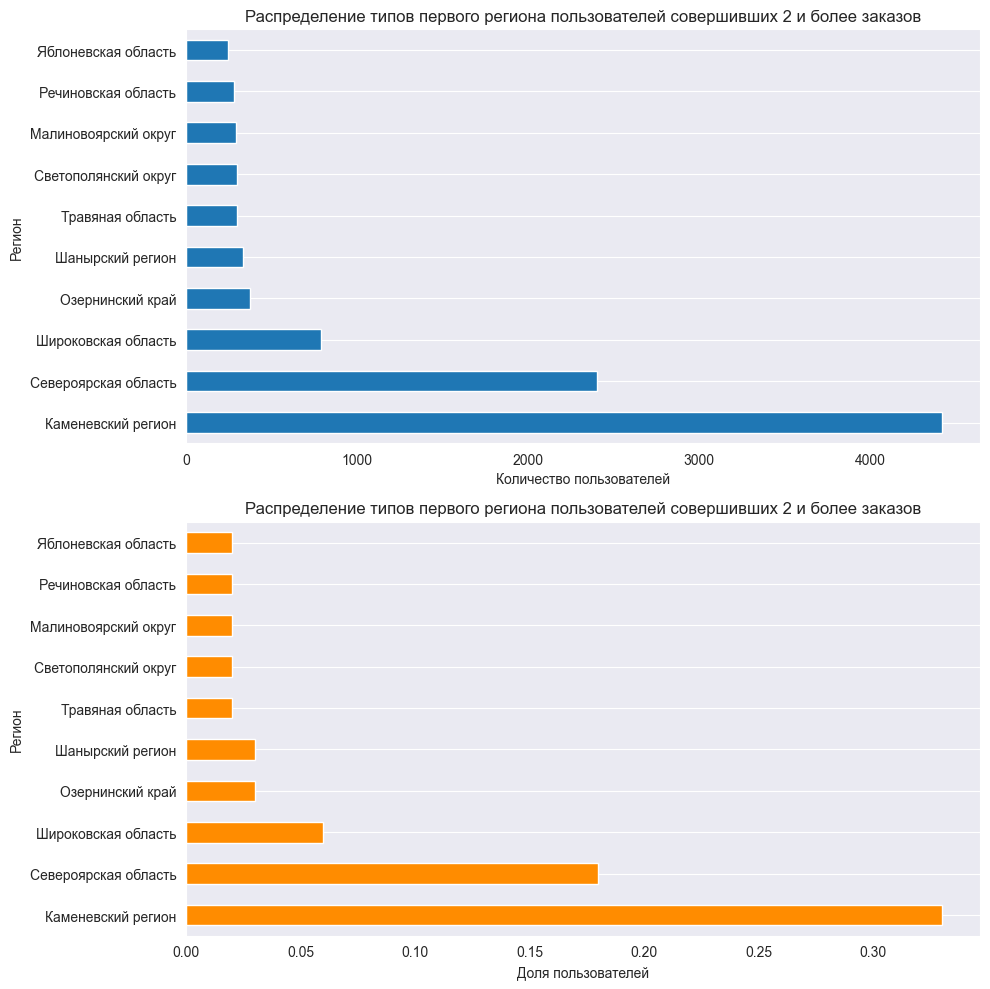

In [67]:
# Распределение типов первого региона пользователей совершивших 2 и более заказов
subplot_distribution(first_region_df_2, 'Распределение типов первого региона пользователей совершивших 2 и более заказов', 
                     'Регион', ['Количество пользователей', 'Доля пользователей'], kind='barh',
                     figsize=(10, 10))

Доли для самых популярных регионов для выборки пользователей сделавших 2 и более заказа практически не отличается. 0.33 против 0.33 для Каменевского региона и 0.18 против 0.17 для Североярской области.

In [68]:
# Распределение типов первого региона пользователей совершивших 2 и более заказов
first_service_df_2 = df_groupby_count_share(filtered_users_profile_is_two, 'first_service_name').head(10)
first_service_df_2

/var/folders/z6/jblpqz354lbgcwl5ph1gnkr00000gn/T/ipykernel_20300/3216612262.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = tmp_df.groupby(groupby).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)


,user_count,user_share
first_service_name,,
Билеты без проблем,3129,0.24
Мой билет,1807,0.14
Лови билет!,1710,0.13
Билеты в руки,1604,0.12
Облачко,1334,0.10
Весь в билетах,808,0.06
Лучшие билеты,725,0.05
Прачечная,365,0.03
Край билетов,296,0.02


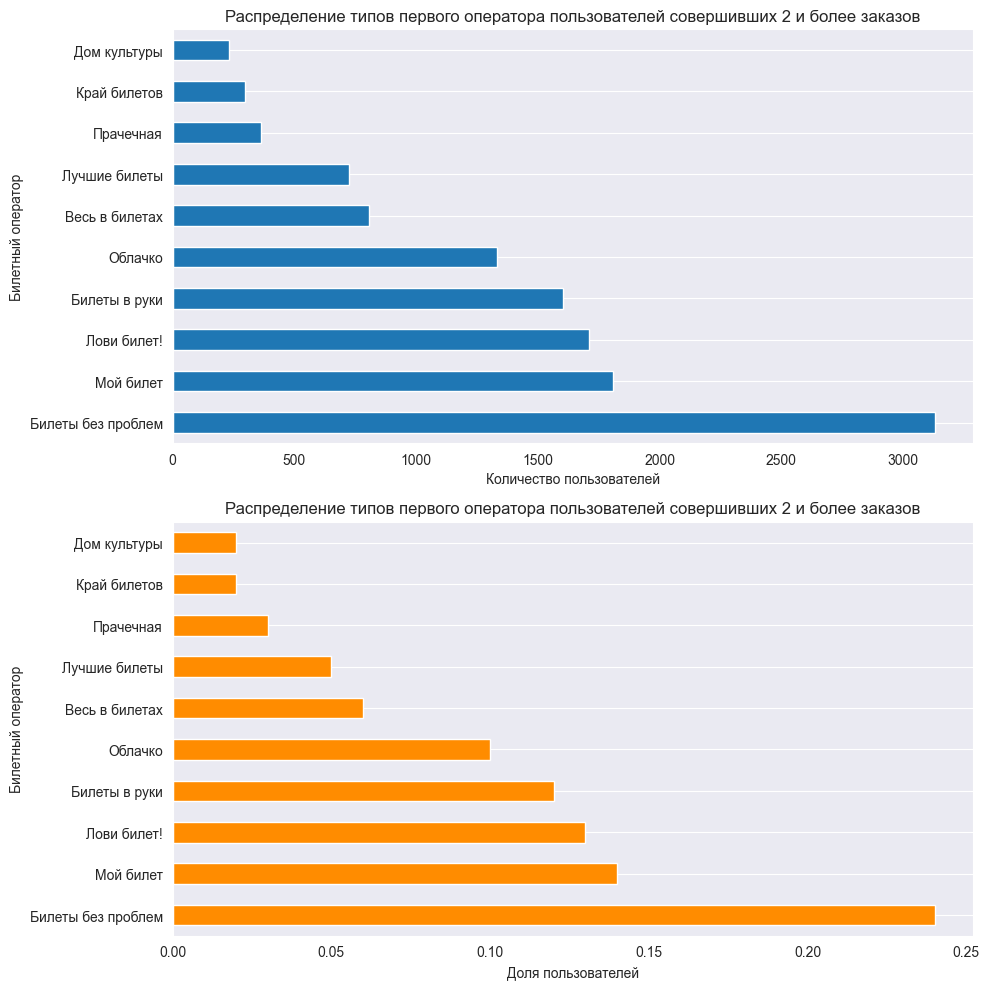

In [69]:
# Распределение типов первого устройства пользователей совершивших 2 и более заказов
subplot_distribution(first_service_df_2, 'Распределение типов первого оператора пользователей совершивших 2 и более заказов', 
                     'Билетный оператор', ['Количество пользователей', 'Доля пользователей'], kind='barh',
                    figsize=(10, 10))

Более 24% пользователей сделали первый заказ у оператора "Билет без проблем".

---
- 45% пользователей сделали первый заказ на концерт, 24% пользователей выбрали "другое".
- 83% пользователей сделали первый заказ с мобильного устройства.
- Наибольшее количество пользователей 33% делали первый заказ из каменевского региона и около 18% из североярскогой области.
- Более 24% пользователей сделали первый заказ у оператора "Билет без проблем".
В результате сравнения между выборками по категориям для пользователей сделавших 2 и более заказа с общей выборкой значительных отличий в самых популярных категориях не выявлено.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Гипотеза 1: Пользователи которые совершили первым заказом сопртивное мероприятие составляют долю 0.4 для общей выборки и 0.3 для пользователей совершивших 2 и более заказов, что говорит об уменьшении повторных заказов среди пользователей выбравших спорт первым заказом.
Концерты первым мероприятием для общей выборки выбрали 0.44, а для пользователей совершивщих 2 и более заказа - 0.45, что говорит о росте повторынх заказов среди пользователей выбравших первым заказов концерт.

---

Гипотеза 2: В целом общая выборка и выборка для пользователей совершивших 2 и более заказов имеет одно и тоже распределение. Доли повторных заказов сопоставимы для активных регионов и менее активных.

---

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [70]:
#Выборка пользователей сделавших только один заказ
user_avg_revenue_one = filtered_users_profile[filtered_users_profile['is_two'] == 0]['avg_revenue']

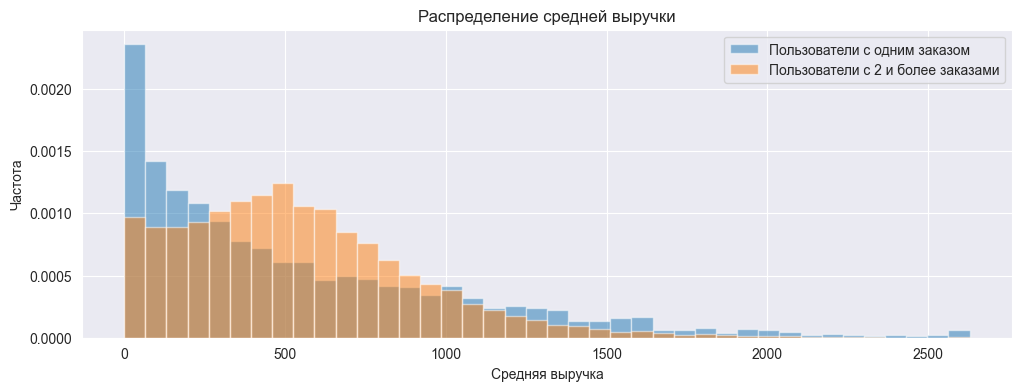

In [71]:
#График распределения 'avg_revenue' среди пользователей
fig, ax = plt.subplots(figsize=(12, 4))
conf = dict(bins=40, alpha=0.5, density=True)
ax.hist(user_avg_revenue_one, label="Пользователи с одним заказом", **conf)
ax.hist(filtered_users_profile_is_two['avg_revenue'], label="Пользователи с 2 и более заказами", **conf)

ax.legend()
ax.set_title("Распределение средней выручки")
ax.set_xlabel("Средняя выручка")
ax.set_ylabel("Частота")

plt.show()

Пользователи сделавшие только один заказ чаще всего делали заказы со средней выручкой стремящейся к нулю, группа пользователей сделавших 2 и более заказа более равномерна распределена в диапазоне от 0 до 1000 рублей.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [72]:
# Выберем 'avg_revenue' для пользователей совершивших от 2 до 4 заказов
user_avg_revenue_two_four = filtered_users_profile[
    (filtered_users_profile['is_two'] == 1) &
    (filtered_users_profile['is_five'] == 0)]

In [73]:
# Выберем 'avg_revenue' для пользователей совершивших 5 и более заказов
user_avg_revenue_five = filtered_users_profile[filtered_users_profile['is_five'] == 1]

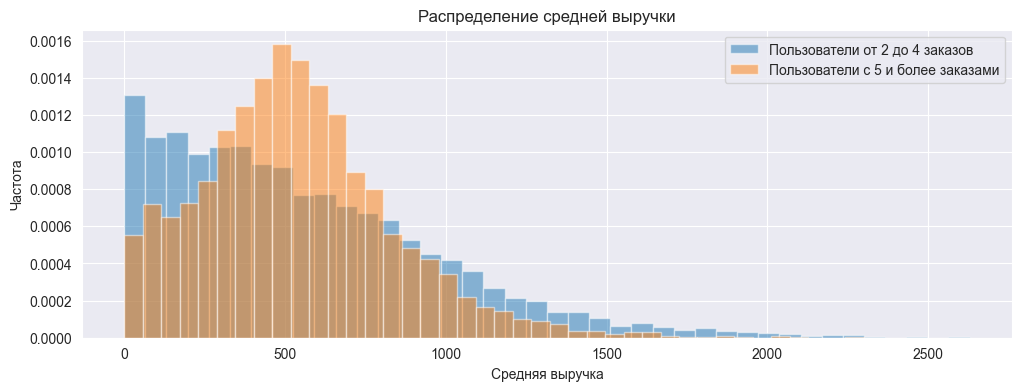

In [74]:
#График распределения 'avg_revenue' среди пользователей
fig, ax = plt.subplots(figsize=(12, 4))
conf = dict(bins=40, alpha=0.5, density=True)
ax.hist(user_avg_revenue_two_four['avg_revenue'], label="Пользователи от 2 до 4 заказов", **conf)
ax.hist(user_avg_revenue_five['avg_revenue'], label="Пользователи с 5 и более заказами", **conf)

ax.legend()
ax.set_title("Распределение средней выручки")
ax.set_xlabel("Средняя выручка")
ax.set_ylabel("Частота")

plt.show()

График для пользователей сделавших от 2 до 4 заказов ассиметричен, пик смещен влево, наиболее частые значения более-менее равномерно распределены от 0 до 500 рублей. Для пользователей с 5 и более заказами график имеет симметричный вид с пиком на отметке 500 рублей, большая часть значений распределена в диапазоне от 25 до 750 рублей.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [75]:
# Добавим категорию со средним количеством билетов на пользователя
bins = [1, 2, 3, 5, 1000]
labels = ['от 1 до 2 билетов', 'от 2 до 3 билетов', 'от 3 до 5 билетов', 'от 5 и более билетов']
filtered_users_profile['avg_ticket_cat'] = pd.cut(filtered_users_profile['avg_tickets_count'], bins=bins, labels=labels, right=False)

In [76]:
# Распределение среднего количества билетов среди пользователей
grouped_avg_tickets =  df_groupby_count_share(filtered_users_profile, 'avg_ticket_cat')
grouped_avg_tickets

/var/folders/z6/jblpqz354lbgcwl5ph1gnkr00000gn/T/ipykernel_20300/3216612262.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = tmp_df.groupby(groupby).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)


,user_count,user_share
avg_ticket_cat,,
от 2 до 3 билетов,9494,0.44
от 3 до 5 билетов,9055,0.42
от 1 до 2 билетов,2412,0.11
от 5 и более билетов,661,0.03


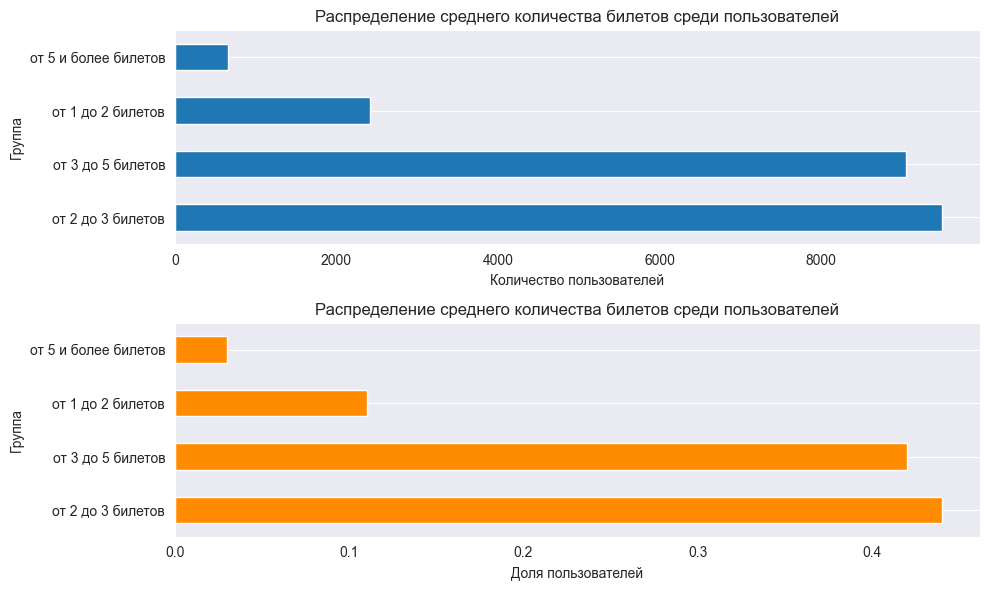

In [77]:
# Распределение среднего количества билетов среди пользователей
subplot_distribution(grouped_avg_tickets, 'Распределение среднего количества билетов среди пользователей', 
                     'Группа', ['Количество пользователей', 'Доля пользователей'], kind='barh')

Группы пользователей распределены неравномерно, более 80% пользователей сконцентрированы в двух группах "от 2 до 3"(42%) и "от 3 до 5 билетов"(43%), самая малочисленная группа "от 5 и более билетов" составила 3%.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [78]:
# Поменяем настройки локали для отображения даты на русском языке
import locale
try:
    locale.setlocale(locale.LC_ALL, 'ru_RU')
except Exception as e:
    print(e)
    print('Доступный список локалей:')
    !locale -a

In [79]:
# Посчитаем количество и долю пользователей для каждого дня недели первой покупки
filtered_users_profile['first_day_of_week'] = filtered_users_profile['first_order_dt'].dt.day_name()
grouped_by_day = df_groupby_count_share(filtered_users_profile, 'first_day_of_week')
grouped_by_day

,user_count,user_share
first_day_of_week,,
Saturday,3324,0.15
Friday,3257,0.15
Tuesday,3175,0.15
Thursday,3110,0.14
Wednesday,3055,0.14
Monday,2925,0.14
Sunday,2776,0.13


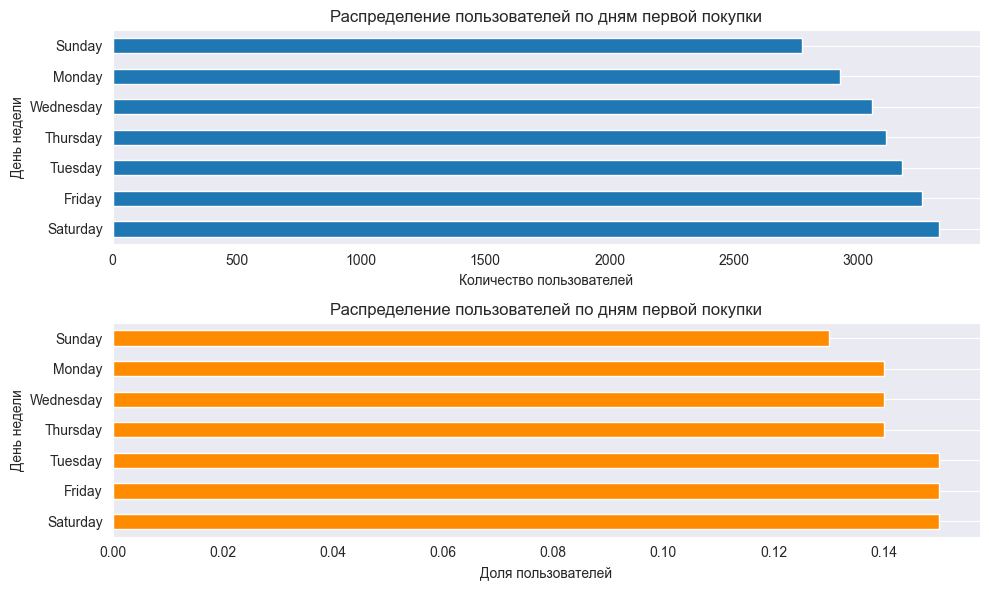

In [80]:
# Распределение среднего количества билетов среди пользователей
subplot_distribution(grouped_by_day, 'Распределение пользователей по дням первой покупки', 
                     'День недели', ['Количество пользователей', 'Доля пользователей'], kind='barh')

Чаще всего пользователи совершают первыйе заказы в пятницу, субботу, четверг и вторник, реже всего в воскресенье.
Врят ли день недели влияет на возврат клиента, скорее решение о покупке билета принимается в день мероприятия или за день до него.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [81]:
avg_days_betwen_orders_two_four = user_avg_revenue_two_four['avg_days_between_orders'].mean()
print(f'Среднее количество дней между заказами для пользователей совершивших 2-4 заказа {avg_days_betwen_orders_two_four:0.02f}')

Среднее количество дней между заказами для пользователей совершивших 2-4 заказа 21.34


In [82]:
avg_days_betwen_orders_five = user_avg_revenue_five['avg_days_between_orders'].mean()
print(f'Среднее количество дней между заказами для пользователей совершивших >5 заказов {avg_days_betwen_orders_five:0.02f}')

Среднее количество дней между заказами для пользователей совершивших >5 заказов 9.91


Интервал между заказами для пользователей совершивших больше 5 заказов меньше интервала для пользователей с 2-4 заказами, следовательно вероятность того, что пользователь с 5 и более заказами сделает новый заказа выше.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [83]:
correlation_matrix = filtered_users_profile[
    ['total_orders', 'first_device_type','first_region_name', 'first_service_name', 
     'first_event_type', 'avg_revenue', 'avg_tickets_count', 'avg_days_between_orders', 
     'avg_ticket_cat', 'first_day_of_week', 'is_two', 'is_five']
].phik_matrix(interval_cols=['avg_revenue', 'avg_tickets_count', 'avg_days_between_orders'])
orders_corr = correlation_matrix.loc[correlation_matrix.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)
orders_corr

,total_orders
is_two,1.000000
is_five,1.000000
avg_days_between_orders,0.492867
first_region_name,0.410635
avg_ticket_cat,0.357234
avg_tickets_count,0.290406
avg_revenue,0.252298
first_device_type,0.066708
first_day_of_week,0.040724
first_service_name,0.000000


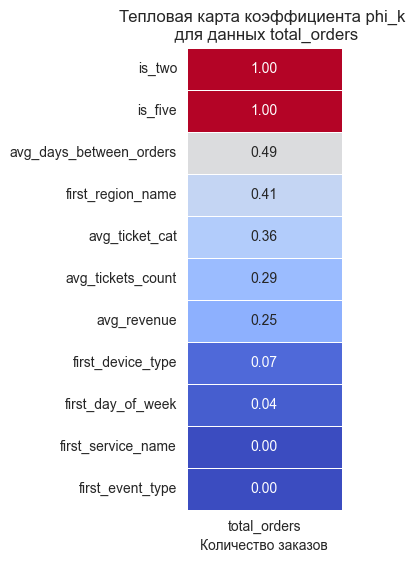

In [84]:
# Строим тепловую карту коэффициента phi_k для total_orders
plt.figure(figsize=(2, 6))
sns.heatmap(orders_corr,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            linewidths=0.5,
            cbar=False
           )
plt.title('Тепловая карта коэффициента phi_k \n для данных total_orders')
plt.xlabel('Количество заказов')

plt.show()

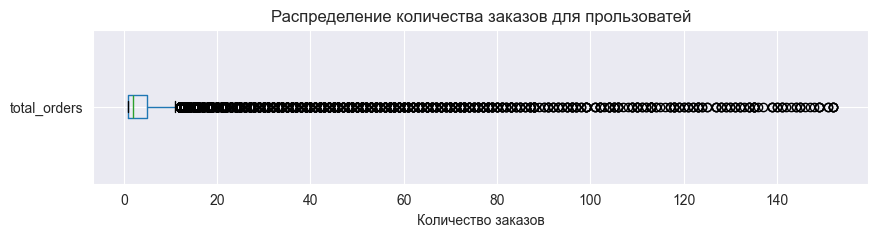

In [85]:
# Распределение количества заказов для прользоватей
value_distribution(filtered_users_profile, 'total_orders', 'Распределение количества заказов для прользоватей', 'Количество заказов')

С количеством заказов наиболее сильную связь имеют признаки `is_two` и `is_five`, по сути это производные от количества заказов.
Признак `avg_days_between_orders` и `first_region_name` имеетю умеренную корреляционную связь с количеством заказов.
Слабую связь имеют признаки `avg_ticket_cat`,  `avg_tickets_count` и `avg_revenue`. 

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

В ходе исследования проанализировали данные двух датасетов, в одном из них были данные о заказах пользователей сервиса Яндекс Афиша, во втором датасете курс валюты казахского тенге к российскому рублю. Датасеты были объединены для того, чтобы рассчитать прибыль в рублях для заказов в тенге.
Данные в колонке `revenue_rub` были отфильтрованы по 95 перцентилю ввиду большоего количества выброса в них. В датафрейме профиля плозователей так же были отфильтрованы значения в колонке `total_orders` по 99 перцентилю из-за выбросов.

Общее число пользователей в выборке 20745; доля пользователей, совершивших 2 и более заказа 0.59; доля пользователей, совершивших 5 и более заказов 0.25.
Общее число заказов 287786; среднее число билетов в заказе 2.74; среднее количество дней между покупками 17.04. В данных обнаружено аномально высокое количество заказов на пользователя в ряде случаев, данные по этому показателю отфильтрованы по 99-му перцентилю. В данных так же обнаружены аномальные заказы с отрицательной выручкой, их тоже отфильтровали в датасете.

Первый регион заказа имеет умеренную связь с количеством заказов.

Среднее количество билетов в заказе и средняя выручка имеют слабую связь с количеством заказов.

Среднее количество дней между заказами имеет умеренную связь с количеством заказов.

Пользователи сделавшие только один заказ чаще всего делали заказы со средней выручкой близкой к нулю, возможно стоит сделать углубленный анализ по этой категории пользователей для выработки стратегии по возврату пользователей.
Группа пользователей со средним количеством билетов от 1 до 2 в первом приближении выглядит слишком малочисленной и составляет долю 0.11 от общего числа, стоит рассмотреть возможность создания условий для увеличения активности данной группы.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**